# Adaptive PDE discretizations on Cartesian grids
## Volume : Divergence form PDEs
## Part : Primal-Dual optimization
## Chapter : Porous medium diffusion via energy minimization

$
\newcommand\vp{\varphi}
\newcommand\bR{\mathbb{R}}
\newcommand\bT{\mathbb{T}}
\newcommand\bZ{\mathbb{Z}}
\newcommand\prox{\mathrm{prox}}
$

A variationnal formulation of diffusion in a porous medium was presented by Y. Brenier in the MOKA10 days, Fontainebleau, 2024. This notebook contains a proof of concept implementation of this approach.

The quadratic model of porous medium diffusion reads 
\begin{align*}
    \partial_t u &= \Delta (u^2/2), &
    u(t=0) = u_0.
\end{align*}
Y. Brenier considers the minimization of the quadratic norm over all weak solutions of this time dependent PDE. After an integration by parts and an $\inf$-$\sup$ interversion, he arrives at the following formulation
\begin{align*}
    &\inf_{\vp} \int_{[0,T] \times \Omega} \frac{(\partial_t \vp)^2}{2(1-\Delta\vp)} + \int_\Omega u_0 \vp(t=0), &
    \vp(t=T) & = 0,
\end{align*}
with the constraint $\Delta \vp \leq 1$ implicitly enforced. 
The minimizer $\vp$ is related to the solution of porous medium diffusion by the relation
\begin{equation*}
    (1-\Delta \vp) u = \partial_t \vp.
\end{equation*}
Denoting $m := \partial_t \vp$ and $\rho := 1-\Delta\vp$, the above optimization problem can also be written as
\begin{align*}
    &\inf_{\rho,m} \int_{[0,T] \times \Omega}
    \frac{m^2}{2\rho} - u_0 m, &
    \partial_t \rho + \Delta m &= 0,& 
    \rho(1) &= 1.
\end{align*}

**A global variational problem in time.**
Time dependent porous medium equation is rephrased, in the formulation above, into a global optimization problem over time and space, which may appear more numerically costly to address. The underlying motivations are that (i) optimization problem solutions come with additional guarantees, (ii) explicit time discretizations would not be usable due to the restrictive time stepping conditions, and (iii) implicit time discretizations also have a high numerical cost.

**Temporal rescaling.**
If $u$ is a solution to the quadratic model of porous medium diffusion problem over $[0,T]$, then $U(s) := \lambda u(\lambda s)$ also is a solution, over the time interval $[0,T/\lambda]$, such as the following : 

**Possible extensions.**
The implementation presented below is only a proof of concept, which leaves open many questions and has numerous natural extensions. 
- Other porous medium models non-linearity models, with the simplest one being $\partial_t u = \Delta (u^p/p)$.
- Anisotropic porous diffusion.
- Boundary conditions. (We are presently using periodic boundary conditions on the torus.)
- Alternative optimization strategies. (We are presently using a Newton method, and a Chambolle-Pock primal-dual method.)
- Higher order schemes. (We currently use a second order scheme in space and time.)

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Exact solution](#1.-Exact-solution)
  * [2. Newton solver in the variable $\vp$.](#2.-Newton-solver-in-the-variable-$\vp$.)
    * [2.1 One dimensional experiment](#2.1-One-dimensional-experiment)
    * [2.2 Two dimensional experiment](#2.2-Two-dimensional-experiment)
  * [3. Chambolle Pock primal-dual algorithm in the variables $\rho$, $m$](#3.-Chambolle-Pock-primal-dual-algorithm-in-the-variables-$\rho$,-$m$)
    * [3.1 Orthogonal projection on the linear constraint](#3.1-Orthogonal-projection-on-the-linear-constraint)
    * [3.2 Proximal operator of the perspective function](#3.2-Proximal-operator-of-the-perspective-function)
    * [3.3 Chambolle-Pock primal-dual optimization](#3.3-Chambolle-Pock-primal-dual-optimization)
    * [3.4 Two dimensions](#3.4-Two-dimensions)
  * [4. Running on the GPU](#4.-Running-on-the-GPU)
    * [4.1 Kernel for the perspective function](#4.1-Kernel-for-the-perspective-function)
    * [4.2 Reproducibility](#4.2-Reproducibility)
    * [4.3 Larger test case](#4.3-Larger-test-case)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if pip package is installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('PorousMinimization','Div'))

In [2]:
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd.ODE import proximal
norminf = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import lsqr as sparse_lsqr
from numpy import fft
π = np.pi
np.set_printoptions(linewidth=2000)

### 0.1 Additional configuration

<!---
def asarray(l):
    if isinstance(l[0],np.ndarray): return np.asarray(l)
    import cupy
    return cupy.asarray(l)
--->

In [4]:
try: 
    import cupy as cp
    from cupy import get_array_module
except ImportError: 
    cp = None
    get_array_module = lambda _:np

## 1. Exact solution

The quadratic model of porous medium diffusion, in a homogeneous medium and without boundary, admits an exact explicit solution due to Barenblatt, see [wikipedia](https://en.wikipedia.org/wiki/Porous_medium_equation).

In [5]:
def Barenblatt(t,x,m=2):
    d = len(x) # space dimension
    β = 1/(d*(m-1)+2)
    α = β*d
    γ = β*(m-1)/(2*m)
    x2 = np.sum(x**2,axis=0)
    # The prefactor 2 corresponds to our normalization Δ(u^2/2)
    return 2* t**(-α) * np.maximum(0,1-γ * t**(-2*β) * x2)**(1/(m-1))

This solution has compact support at any given time, has a radial symmetry, and is self similar up to rescaling.

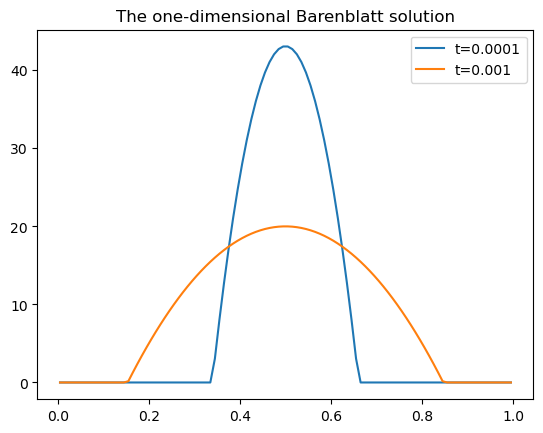

In [6]:
nX = 100
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX += dx/2 # Discretization points at the cell centers
X = aX[None] # Add one axis to indicate dimension 1

plt.title("The one-dimensional Barenblatt solution")
for t in (1e-4,1e-3): 
    plt.plot(aX,Barenblatt(t,X-0.5),label=f"{t=}")
plt.legend();

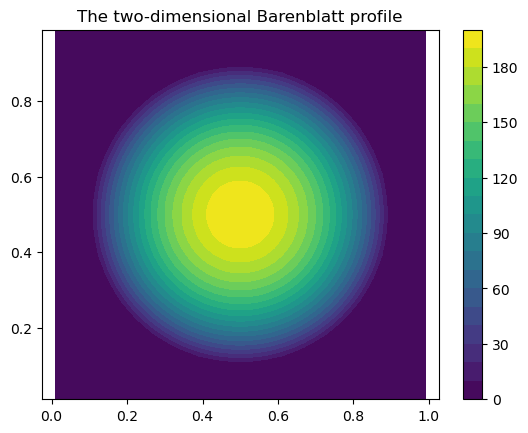

In [7]:
nX = 50
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX += dx/2 # Discretization points at the cell centers
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

plt.title("The two-dimensional Barenblatt profile")
t=1e-4
plt.contourf(*X, Barenblatt(t,X-0.5),levels=20)
plt.axis('equal'); plt.colorbar();

## 2. Newton solver in the variable $\vp$.

We choose the domain $\Omega := \bT^d$, for simplicity, where $\bT := \bR/\bZ$. 

The solution $\vp$ is stored at times $0,dt,\cdots,T-dt$, where $dt = T/n_t$. 


In [8]:
def Dt_Δ(ϕ,dx,dt):
    """
    Returns approximations of dϕ/dt and Δϕ, computed using upwind and centered finite differences respectively.
    The approximations are second order consistent with the values of these functions at time 
    (k+0.5)dt and k dt respectively, where k is the time step index.
    """
    e = np.eye(ϕ.ndim).astype(int)
    et = e[:,0]; ex = e[:,1:] # Time axis is the first one, space axes are the other ones
    Dtϕ = fd.DiffUpwind(ϕ,et,dt,padding=0) # Null boundary condition at the final time
    Dxxϕ = fd.Diff2(ϕ,ex,dx,padding=None) # Periodic space boundary conditions
    Δϕ = Dxxϕ.sum(axis=0)
    return Dtϕ,Δϕ
    

def iΔ_from_Δ(Δϕ,Δϕpos=0.5):
    """
    Returns an approximation of 1/(1-Δϕ), and max(Δϕ).
    The approximation is second order consistent with the value at (k + Δϕpos)*dt,
    where k is the time step index. If Δϕpos = 0.5, then this matches with the time derivative.
    """
    Δmax = np.max(ad.remove_ad(Δϕ)) if Δϕpos<1 else np.max(ad.remove_ad(Δϕ)[:-1],initial=0)
    
    iΔϕ0 = 1/(1-Δϕ)
    iΔϕ1 = np.roll(iΔϕ0,-1,axis=0).copy()
    iΔϕ1[-1] = 1
    iΔϕ = iΔϕ0*(1-Δϕpos)+iΔϕ1*Δϕpos
    
    return iΔϕ,Δmax

def u_from_ϕ(ϕ,dx,dt):
    """Expresses the solution u of the porous diffusion, in terms of ϕ of the optimization"""
    Dtϕ,Δϕ = Dt_Δ(ϕ,dx,dt)
    iΔϕ,_ = iΔ_from_Δ(Δϕ)
    return Dtϕ * iΔϕ

def Energy_ϕ(ϕ,u0,dx,dt,*args):
    """Energy of the variational formulation of the quadratic porous medium equation, in the variable ϕ"""
    ϕ = ϕ.reshape((-1,*u0.shape))
    Dtϕ,Δϕ = Dt_Δ(ϕ,dx,dt)
    iΔϕ, Δmax = iΔ_from_Δ(Δϕ,*args)
    if Δmax>=1: return np.inf # 
    
    interior = Dtϕ**2 * iΔϕ / 2
    boundary = u0*ϕ[0]
    ad.simplify_ad(interior) # Optional. Sometimes speeds up the sparse matrix assembly
    return dt*np.sum(interior)+np.sum(boundary)

### 2.1 One dimensional experiment

In [9]:
nX = 200; nT = 20
#nX = 5; nT=1
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4
u0 = Barenblatt(Ti,X-0.5)
Tf = 1e-3; T = Tf-Ti
dt = T/nT

In [10]:
%%time
# Solve the optimization problem in ϕ
ϕ0 = np.zeros((nT,nX))
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(u0,dx,dt),step_min=1e-8,maxiter=60)
ϕ = ϕ.reshape(ϕ0.shape)

# Reconstruct the solution u
u = u_from_ϕ(ϕ,dx,dt)

Initialization, objective 0.0
Iteration 1, Newton step 0.5, objective -11.014643689455571.
Iteration 2, Newton step 0.00048828125, objective -11.110182691945269.
Iteration 3, Newton step 0.0009765625, objective -11.218007929030293.
Iteration 4, Newton step 0.001953125, objective -11.363863425933838.
Iteration 5, Newton step 0.001953125, objective -11.461428493399639.
Iteration 6, Newton step 0.00390625, objective -11.60837239697181.
Iteration 8, Newton step 0.00390625, objective -11.806837053698871.


Iteration 10, Newton step 0.0078125, objective -12.080206936545691.
Iteration 12, Newton step 0.0078125, objective -12.28405620492728.
Iteration 14, Newton step 0.015625, objective -12.606074516712697.
Iteration 16, Newton step 0.015625, objective -12.864709234496981.


Iteration 20, Newton step 0.03125, objective -13.653436544203693.
Iteration 24, Newton step 0.03125, objective -14.22546529802684.


Iteration 28, Newton step 0.0625, objective -15.066475000836272.
Iteration 32, Newton step 0.125, objective -15.99256119550941.


Iteration 36, Newton step 0.25, objective -16.695868608666558.
Iteration 40, Newton step 0.25, objective -17.218510773069276.


Iteration 44, Newton step 1.0, objective -17.38319910123505.
Iteration 48, Newton step 1.0, objective -17.387508880563427.
Convergence criterion satisfied, terminating.
Iteration 52, Newton step 1.0, objective -17.38750896717683.
CPU times: user 1.21 s, sys: 86.8 ms, total: 1.3 s
Wall time: 1.3 s


The exact and numerical solution agree quite well. 
The numerical solution has global support, unlike the exact one, but the corresponding values are infinitesimal.

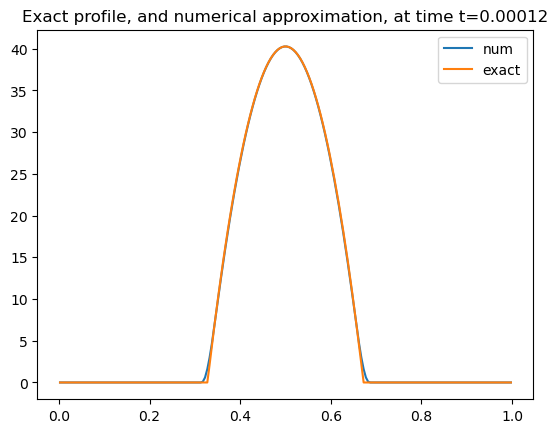

In [11]:
iT=0
t = Ti+(iT+0.5)*dt # Remember to shift by half a time step.
plt.title(f"Exact profile, and numerical approximation, at time {t=:.5f}")
plt.plot(aX,u[iT],label="num")
plt.plot(aX,Barenblatt(t,X-0.5),label="exact")
plt.legend();

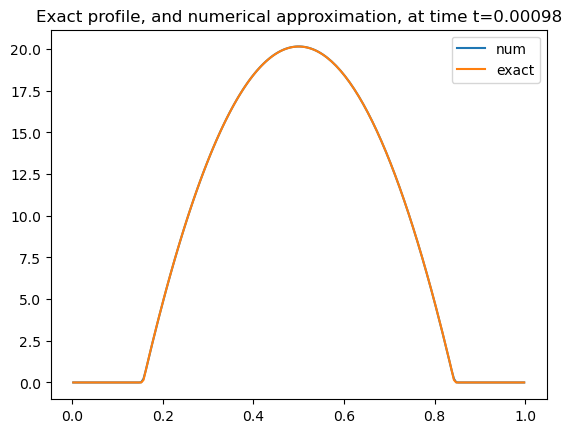

In [12]:
iT=nT-1
t = Ti+(iT+0.5)*dt
plt.title(f"Exact profile, and numerical approximation, at time {t=:.5f}")
plt.plot(aX,u[iT],label="num")
plt.plot(aX,Barenblatt(Ti+(iT+0.5)*dt,X-0.5),label="exact")
plt.legend();

### 2.2 Two dimensional experiment

In [13]:
nX = 35; nT = 6
#nX = 50; nT = 10 # bit longish
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT

In [14]:
%%time
# Solve the optimization problem in ϕ
ϕ0 = np.zeros((nT,*u0.shape))
ϕ = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(u0,dx,dt),step_min=1e-8)
ϕ = ϕ.reshape(ϕ0.shape)

# Reconstruct the solution u
u = u_from_ϕ(ϕ,dx,dt)

Initialization, objective 0.0
Iteration 1, Newton step 0.25, objective -375.00252143382437.


Iteration 2, Newton step 0.015625, objective -390.29833868581727.


Iteration 3, Newton step 0.03125, objective -411.08550984013954.


Iteration 4, Newton step 0.0625, objective -445.2442065697418.


Iteration 5, Newton step 0.125, objective -501.35118125756804.


Iteration 6, Newton step 0.125, objective -545.710499092698.


Iteration 8, Newton step 0.25, objective -639.5673191194612.


Iteration 10, Newton step 0.25, objective -732.8048550574883.


Iteration 12, Newton step 1.0, objective -781.871964813331.


Iteration 14, Newton step 1.0, objective -788.6039250223354.


Iteration 16, Newton step 1.0, objective -788.6379423429379.


Convergence criterion satisfied, terminating.
Iteration 20, Newton step 1.0, objective -788.6380038064068.
CPU times: user 15.3 s, sys: 18.2 s, total: 33.5 s
Wall time: 20.9 s


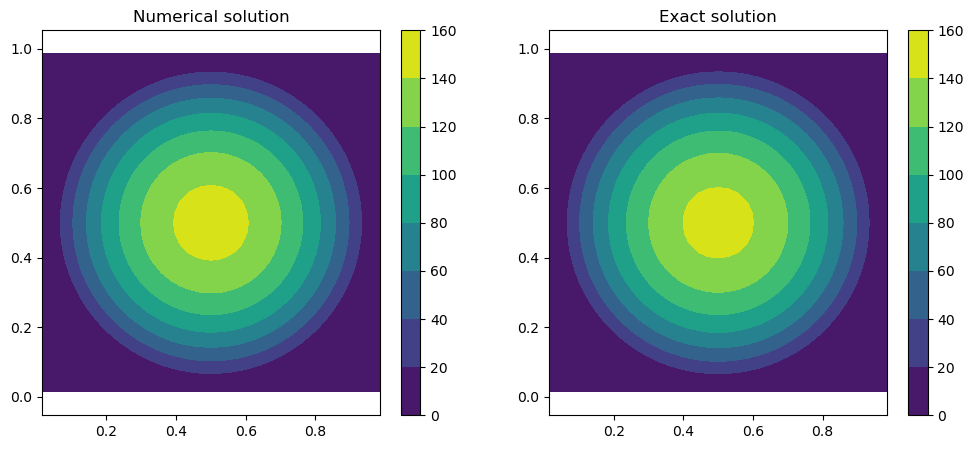

In [15]:
iT=nT-1
t = Ti+(iT+0.5)*dt
plt.figure(figsize=[12,5])
plt.subplot(1,2,1); plt.title("Numerical solution")
plt.contourf(*X,u[iT])
plt.axis('equal'); plt.colorbar();
plt.subplot(1,2,2); plt.title("Exact solution")
plt.contourf(*X,Barenblatt(t,X-0.5))
plt.axis('equal'); plt.colorbar();

## 3. Chambolle Pock primal-dual algorithm in the variables $\rho$, $m$

The objective is to solve :
\begin{align*}
    &\inf_{\rho,m} \int_{[0,T] \times \Omega}
    \frac{m^2}{2\rho} - u_0 m, &
    \partial_t \rho + \Delta m &= 0,& 
    \rho(T) &= 1.
\end{align*}

The unknowns of this formulation are related to the previous one by 
\begin{align*}
    m &= \partial_t \vp, &
    \rho &= 1 - \Delta \vp.
\end{align*}


**Numerical implementation** 
Consistently with the previous formulation, the variable $m$ is stored at the times $dt/2,3dt/2,...$, and the variable $\rho$ at the times $0,dt,2dt,...$.

In order to ease the implementation, we extend $\rho$ by symmetry, and $m$ by anti-symmetry, in the *time variable*, so as to make them $2T$ periodic. This has the following advantages : 
- Simpler implementation of Fourier transforms, in time (and space).
- Simpler implementation of the proximal operator of the perspective function, thanks to decoupling. 

The discretization presented in this section is *exactly equivalent* to the previous one. However, we shall use different numerical solvers. 

In [16]:
def ρm_from_ϕ(ϕ,dx,dt):
    """Construct ρ and m from ϕ, including the periodic extension."""
    Dtϕ,Δϕ = Dt_Δ(ϕ,dx,dt) # Finite difference scheme
    xp = get_array_module(ϕ)
    m = xp.concatenate([Dtϕ,-Dtϕ[::-1]],axis=0) # Anti-symmetric extension
    ρ = xp.concatenate([1-Δϕ,np.ones_like(ϕ[:1]),1-Δϕ[1:][::-1]],axis=0) # Symmetric extension
    return ρ,m

def Energy_ρm(ρ,m,u0):
    """int m^2/(2ρ) - u0m. Assumes the constraints are satisfied."""
    nT=len(m)//2
    return np.sum(m**2/(2*ρ))-np.sum(u0*(-m[nT:]+m[:nT]))

def u_from_ρm(ρ,m):
    """Reconstruct the solution u from ρ and m"""
    nT=len(ρ)//2
    iρ = 1/ρ+1/np.roll(ρ,-1,axis=0)
    return (m[:nT]-m[nT:][::-1])*(iρ[:nT]+iρ[nT:][::-1])/8

In [17]:
ρ,m = ρm_from_ϕ(ϕ,dx,dt) # Check that the energy is correctly reproduced
assert np.allclose(Energy_φ(ϕ,u0,dx,dt),(dt/2)*Energy_ρm(ρ,m,u0))
assert np.allclose(u_from_ρm(ρ,m),u_from_ϕ(ϕ,dx,dt))

### 3.1 Orthogonal projection on the linear constraint 

The unknowns obey the linear constraints
\begin{align*}
    \partial_t \rho + \Delta m &= 0,& 
    \rho(t) &= \rho(2T-t), &
    m(t) &= -m(2T-t).
\end{align*}
In order to implement the primal dual method, we need to orthogonally project onto the set of unknowns obeying these constraints. Note that the constraint $\rho(t) = \rho(2T-t)$ is redundant with the others, hence it can be removed.

In [18]:
def cstr_ρm(ρ,m,dx,dt):
    """The residues of the linear constraints Dtρ + Δm = 0 and  m(t) = -m(2T-t)"""
    e = np.eye(ρ.ndim).astype(int)
    et = e[:,0]; ex = e[:,1:] # Time axis is the first one, space axes are the other ones
    Dtρ = fd.DiffUpwind(ρ,et,dt,padding=None) # Now using *periodic* time boundary conditions
    Dxxm = fd.Diff2(m,ex,dx,padding=None) # Periodic space boundary conditions
    Δm = Dxxm.sum(axis=0)
    nT = len(m)//2
    return dt*(Dtρ+Δm), m[:nT]+m[nT:][::-1] # dt introduced for normalization

The variables derived from the numerical solution of the previous formulation obey the constraints.

In [19]:
cstr_cont,cstr_sym = cstr_ρm(ρ,m,dx,dt)
assert np.allclose(cstr_cont,0)
assert np.allclose(cstr_sym,0)

In order to check our results, we first use a linear solver to compute the projection.
This is much less efficient than a Fourier transform, but it is also less tricky to implement, and completely independent.

In [20]:
def make_proj_ρm(ρ,m,dx,dt):
    ρ_ad,m_ad = ad.Sparse.register((ρ,m))
    cstr_ad = cstr_ρm(ρ_ad,m_ad,dx,dt)
    A = np.concatenate(cstr_ad,axis=0).tangent_operator()
    def proj(ρ,m):
        y0 = np.concatenate((ρ,m),axis=0)
        sol = sparse_lsqr(A,-A*y0.reshape(-1))
        y = sol[0].reshape(y0.shape) + y0
        return y[:len(y)//2],y[len(y)//2:]
    return proj

In [21]:
np.random.seed(42)
ρ_rnd,m_rnd = [np.random.rand(*e.shape)-0.5 for e in (ρ,m)]
proj = make_proj_ρm(ρ,m,dx,dt)
ρ_proj,m_proj = proj(ρ_rnd,m_rnd)

# Note : we may need to scale the constraints for better results
cstr_cont,cstr_sym = cstr_ρm(ρ_rnd,m_rnd,dx,dt)
print(f"Initial error. Continuity equation : {norminf(cstr_cont)}, Symmetry {norminf(cstr_sym)}")
cstr_cont,cstr_sym = cstr_ρm(ρ_proj,m_proj,dx,dt)
print(f"After projection. Continuity equation : {norminf(cstr_cont)}, Symmetry {norminf(cstr_sym)}")

Initial error. Continuity equation : 1.0691671350433674, Symmetry 0.9925016477866847
After projection. Continuity equation : 1.0186062044757023e-05, Symmetry 3.3352185788149136e-06


Now the Fourier implementation of the projection.

In [22]:
def Fourier_proj_ρm(ρ,m,dx,dt,verb=1):
    # Built the coordinate axes in Fourier space, ranging from 0 to 1.
    ξ = [np.arange(n,like=ρ,dtype=ρ.dtype).reshape( (1,)*i + (-1,) + (1,)*(ρ.ndim-1-i) )/n for (i,n) in enumerate(ρ.shape)]
    ξT = ξ[0]
    ξX = ξ[1:]
    
    nT = len(ρ)//2
    Ftρ = fft.fft(ρ,axis=0) # Fourier wrt time variable
    Ftm = fft.fft(m,axis=0)*np.exp(-1j*ξT*π) # Take half period time shift into account
    if verb>0: print("Should be zero if ρ is already symmetric : ", norminf(Ftρ.imag)) 
    if verb>0: print("Should be zero if m is already anti-symmetric : ",norminf(Ftm.real))
    
    Ftρ = Ftρ.real # Project onto symmetric functions 
    Ftm = Ftm.imag # * 1j # Project onto antisymmetric functions, omitting 1j

    space_axes = tuple(range(1,m.ndim)) # Fourier w.r.t space variable
    Fρ = fft.fftn(Ftρ,axes=space_axes)
    Fm = fft.fftn(Ftm,axes=space_axes)

    # Fourier transforms of the finite difference operators
    FDt = 2*np.sin(π*ξT)/dt # * 1j # Time finite difference, omitting 1j
    FDxx = [2*(np.cos(2*π*ξ)-1) / dx**2 for ξ in ξX]
    FΔ = sum(FDxx)
    Fsum = FDt*Fρ + FΔ*Fm
    if verb>0: print("Should be zero if Dtρ+Δm = 0 is already satisfied : ",norminf(Fsum)) # 
    F2 = FDt**2+FΔ**2
    F2[(0,)*ρ.ndim]=1
    Fsum/=F2
    
    Fρ -= Fsum*FDt
    Fm -= Fsum*FΔ
    
    ρ_new = fft.ifftn(Fρ)
    m_new = fft.ifftn(Fm * 1j * np.exp(1j*ξT*π) )
    if verb>0: print("Should be zero if ρ and m already satisfy the constraints :",norminf(ρ_new-ρ),",",norminf(m_new-m))
    if verb>0: print("Should be zero for real variables :",norminf(ρ_new.imag),",",norminf(m_new.imag))
    
    return ρ_new.real,m_new.real

In [23]:
Fourier_proj_ρm(ρ,m,dx,dt);

Should be zero if ρ is already symmetric :  1.239037099348071e-16
Should be zero if m is already anti-symmetric :  3.3171476277570265e-13
Should be zero if Dtρ+Δm = 0 is already satisfied :  9.961454485732623e-08
Should be zero if ρ and m already satisfy the constraints : 2.0208800159030324e-14 , 1.7078530854198776e-13
Should be zero for real variables : 1.1086054133898862e-14 , 9.046559891949336e-14


In [24]:
ρ_Fproj,m_Fproj = Fourier_proj_ρm(ρ_rnd,m_rnd,dx,dt);

Should be zero if ρ is already symmetric :  2.496353763931597
Should be zero if m is already anti-symmetric :  3.465175535843146
Should be zero if Dtρ+Δm = 0 is already satisfied :  5707186.727367198
Should be zero if ρ and m already satisfy the constraints : 0.7169262069159161 , 0.5649541436927441
Should be zero for real variables : 1.0820433571681338e-16 , 2.375204410083769e-16


We get a few percent difference for the projections, possibly because the least squares approach is not very accurate (involves a $10^{-6}$ tolerance), and we use a rather small time step dt.

In [25]:
print("Relative max difference of projections ",norminf(ρ_Fproj - ρ_proj)/norminf(ρ_proj), norminf(m_Fproj-m_proj)/norminf(m_proj))

Relative max difference of projections  4.252656594050717e-05 1.2532202519532199e-05


In [26]:
cstr_cont,cstr_sym = cstr_ρm(ρ_Fproj,m_Fproj,dx,dt)
print(f"After projection. Continuity equation : {norminf(cstr_cont)}, Symmetry {norminf(cstr_sym)}")

After projection. Continuity equation : 1.77351466845721e-16, Symmetry 3.3306690738754696e-16


In [27]:
print("Checking orthogonality of projection :", np.sum(ρ_Fproj * (ρ_rnd-ρ_Fproj) ) + np.sum(m_Fproj * (m_rnd-m_Fproj) ))

Checking orthogonality of projection : 1.2290168882600483e-13


### 3.2 Proximal operator of the perspective function


The perspective function is defined as 
$$
    g(\eta,y) := \frac{\|y\|^2}{2 \eta}
$$
According to Example 3.8 in the reference below, one has 
\begin{align*}
    \prox_{\tau g}(\eta,y) &= (0,0), &
    \text{if } \tau \eta+\|y\|^2/2 &\leq 0,
\end{align*}
and otherwise
\begin{align*}
    \prox_{\tau g}(\eta,y) &= \Big(\eta+\frac{\tau s^2} 2, \big(1-\frac{\tau s}{\|y\|}\big) y\Big), &
    \text{where } 0 &= P(s):=\tau s^3 + 2(\eta+\tau) s-2\|y\|.
\end{align*}
The discriminant of $P$ is negative for all $\tau>0$, $\eta\geq 0$ and $(\eta,y)\neq (0,0)$, hence it has a single real root. Since $P(0)\leq 0$, this root is non-negative. Since $P''(0)=0$, the polynomial $P$ is convex over $[0,\infty[$. A Newton method initialized above the root will converge without damping.

Combettes, P. L. & Müller, C. L. Perspective functions: Proximal calculus and applications in high-dimensional statistics. Journal of Mathematical Analysis and Applications 457, 1283–1306 (2018).

<!---
η=xtest[0]; y=xtest[1:]; Ny=np.linalg.norm(y,axis=0)
to_origin = τ*η+Ny**2/2<=0
xtest2 = xtest[:,~to_origin]
xtest3 = xtest2[:,3496]
print(xtest2.shape)
prox_perspective(1,xtest,200)
--->

In [28]:
def perspective(x):
    η = x[0]; y = x[1:]; Ny2 = np.sum(y**2,axis=0)
    return np.where(η<=0,np.where(Ny2==0,0,np.inf),Ny2/(2*η))

def prox_perspective(τ,x,niter=12,verb=1,cupy_kernel=True):
    xp = get_array_module(x)
    if xp is not np and cupy_kernel: return prox_perspective_cupy(τ,x,niter) # GPU kernel
    η = x[0]; y = x[1:]
    Ny=np.linalg.norm(y,axis=0)
    to_origin = τ*η+Ny**2/2<=0 # Wether prox is attained at the origin
    s = np.maximum( (2*Ny/τ)**(1/3), np.maximum(0,-2*(η+τ)/τ)**(1/2) ) # Over estimate the root
    for i in range(niter): # Fixed number of Newton iterations, without damping
        s -= (τ*s**3 + 2*(η+τ)*s - 2*Ny)/(3*τ*s**2+2*(η+τ)) 
    sol = xp.concatenate(((η+τ*s**2/2)[None],np.where(Ny==0,0,1-τ*s/Ny)*y),axis=0)
    residue = np.where(to_origin,0,τ*s**3 + 2*(η+τ)*s - 2*Ny)
    if verb>=0 and norminf(residue)>1e-4:
        print("Should be zero if Newton perspective converged :",norminf(residue),"at",np.argmax(np.abs(residue))) 
    return np.where(to_origin,np.zeros_like(x),sol)

Let us check this implementation using automatic differentiation

In [29]:
np.random.seed(42)
x0 = np.random.rand(2,1000)-0.5
τ = 0.5
x = prox_perspective(τ,x0)
x_ad = ad.Dense.identity(constant=x,shape_free=(2,))
δx = perspective(x_ad).gradient()
pos = x[0]>0
print("Should be zero :", norminf((x-x0+τ*δx)[:,pos]))

Should be zero : 2.098321516541546e-14


/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:75: RuntimeWarning: invalid value encountered in divide
  return self.new(self.value/other.value,
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:76: RuntimeWarning: divide by zero encountered in divide
  _add_coef(_add_dim(1/other.value)*self.coef,
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:76: RuntimeWarning: invalid value encountered in multiply
  _add_coef(_add_dim(1/other.value)*self.coef,
/Users/jean-mariemirebeau/Dropbox/Programmes/GithubM1/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Dense.py:77: RuntimeWarning: invalid value encountered in divide
  _add_dim(-self.value/other.value**2)*other.coef))


We now need to implement the proximal operator of the function
\begin{align*}
&\int_{[0,T] \times \Omega}
    \frac{m^2}{2\rho} - u_0 m, &
    \text{subject to the constraint }\rho(T)&=1.
\end{align*}

In [30]:
def prox_obj(τ,ρ0,m0,u0):
    """Proximal operator of the objective function m^2/(2ρ)-u0 m, with constraint ρ(T)=1."""
    nT = len(ρ0)//2
    ϵ = np.zeros_like(u0,shape=(2*nT,*(1,)*(ρ0.ndim-1)))
    ϵ[:nT] = 1; ϵ[nT:] = -1 # Signs corresponding to the anti-symmetric extension of m
    xp = get_array_module(u0)
    x0 = xp.asarray([ρ0,m0+τ*ϵ*u0]) 
    x = prox_perspective(τ,x0)
    ρ = x[0]; m = x[1]
    ρ[nT] = 1 # Enforce the constraint, and use explicit prox for the quadratic objective
    m[nT] = (m0[nT]-τ*u0)/(1+τ) # Caution : anti-symmetric extension of m
    return ρ,m

### 3.3 Chambolle-Pock primal-dual optimization

We implement a very basic primal-dual optimization method, with a fixed number of iterations, without checking the duality gap, and without the various accelerations that have been proposed in the literature.

**Parameter setting and normalization.**
Proximal methods are inhomogeneous, which means that they do not respect the scaling invariances of the problem.
For this reason, problem normalization and parameter setting are non-trivial. 

In [31]:
def init_CP(u0,nT):
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = np.concatenate([(u0,)*nT,(-u0,)*nT],axis=0)
    return ρ,m

def run_CP(u0,dx,dt,nT,τ_f=1,verb=0,maxiter=1000):
    # Normalization of the initial condition
    Nu0 = np.sqrt(np.sum(u0**2)/u0.dtype.type(u0.size)) # Averaged L2 norm of u0
    u0 = u0/Nu0
    dt = dt*Nu0
    
    # Initialization
    xp=get_array_module(u0)
    ρ = np.ones_like(u0,shape=(2*nT,*u0.shape))
    m = xp.asarray([*(u0,)*nT,*(-u0,)*nT])
    x = xp.asarray([ρ,m]) # x contains the pair of variables ρ,m
    y = np.zeros_like(x) # Dual variable
    tx = x.copy()

    # Proximal operators and time steps
    def prox_f(x,τ): return xp.asarray(prox_obj(τ,x[0],x[1],u0))
    def prox_g(x,τ=1): return xp.asarray(Fourier_proj_ρm(x[0],x[1],dx,dt,verb=0))
    def prox_gs(y,τ=1): return y-prox_g(y) # Projection onto orthogonal space
    τ_gs = 1/τ_f # One needs τ_f τ_gs |K|^2 <1, but the coupling operator is the identity

    for i in range(maxiter): # Primal-dual optimization loop
        y = prox_gs(y+τ_gs*tx,τ_gs)
        xold=x
        x = prox_f(x-τ_f*y,τ_f)
        tx = 2*x-xold        
    return x[0],x[1]*Nu0 # Put back the normalization

In [32]:
nX = 200; nT = 20
#nX = 100; nT = 10
#nX = 5; nT=2
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = aX[None]

Ti = 1e-4; Tf = 1e-3; T = Tf-Ti; u0 = Barenblatt(Ti,X-0.5)
#u0*=T; T = 1
#u0 = np.ones_like(X[0])
#np.random.seed(42); u0 = np.random.rand(*X[0].shape)
#u0 = np.zeros_like(X[0]); u0[nX//2]=0.2
dt = T/nT

# Compute the Newton solution
ϕ0 = np.zeros((nT,nX))
ϕN = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(u0,dx,dt),step_min=1e-8,maxiter=60)
ϕN = ϕN.reshape(ϕ0.shape)
ρN,mN = ρm_from_ϕ(ϕN,dx,dt)

Initialization, objective 0.0
Iteration 1, Newton step 0.5, objective -11.014643689455571.
Iteration 2, Newton step 0.00048828125, objective -11.110182691945269.
Iteration 3, Newton step 0.0009765625, objective -11.218007929030293.
Iteration 4, Newton step 0.001953125, objective -11.363863425933838.
Iteration 5, Newton step 0.001953125, objective -11.461428493399639.


Iteration 6, Newton step 0.00390625, objective -11.60837239697181.


Iteration 8, Newton step 0.00390625, objective -11.806837053698871.


Iteration 10, Newton step 0.0078125, objective -12.080206936545691.
Iteration 12, Newton step 0.0078125, objective -12.28405620492728.
Iteration 14, Newton step 0.015625, objective -12.606074516712697.


Iteration 16, Newton step 0.015625, objective -12.864709234496981.


Iteration 20, Newton step 0.03125, objective -13.653436544203693.


Iteration 24, Newton step 0.03125, objective -14.22546529802684.


Iteration 28, Newton step 0.0625, objective -15.066475000836272.


Iteration 32, Newton step 0.125, objective -15.99256119550941.


Iteration 36, Newton step 0.25, objective -16.695868608666558.


Iteration 40, Newton step 0.25, objective -17.218510773069276.


Iteration 44, Newton step 1.0, objective -17.38319910123505.


Iteration 48, Newton step 1.0, objective -17.387508880563427.


Convergence criterion satisfied, terminating.
Iteration 52, Newton step 1.0, objective -17.38750896717683.


In [33]:
%%time
ρCP,mCP = run_CP(u0,dx,dt,nT,τ_f=1,maxiter=2000)
print("ρ relative error",norminf(ρCP-ρN)/norminf(ρN))
print("m relative error",norminf(mCP-mN)/norminf(mN))

ρ relative error 0.1835773656374541
m relative error 0.006314748587102064
CPU times: user 3.52 s, sys: 230 ms, total: 3.75 s
Wall time: 3.75 s


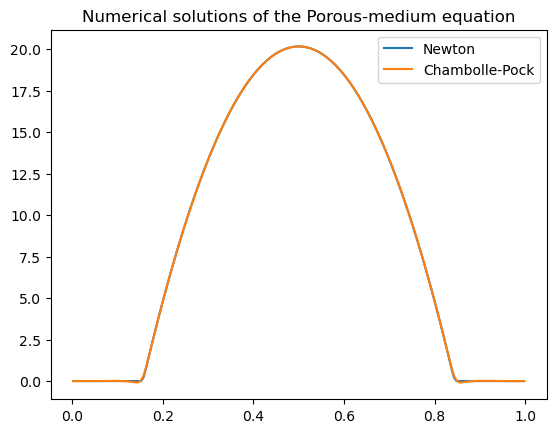

In [34]:
uN = u_from_ρm(ρN,mN); uCP = u_from_ρm(ρCP,mCP)

iT = nT-1 # Choose from 0 (initial condition) to  nT-1 (final time)
plt.title("Numerical solutions of the Porous-medium equation")
plt.plot(aX,uN[iT],label="Newton")
plt.plot(aX,uCP[iT],label="Chambolle-Pock")
plt.legend();

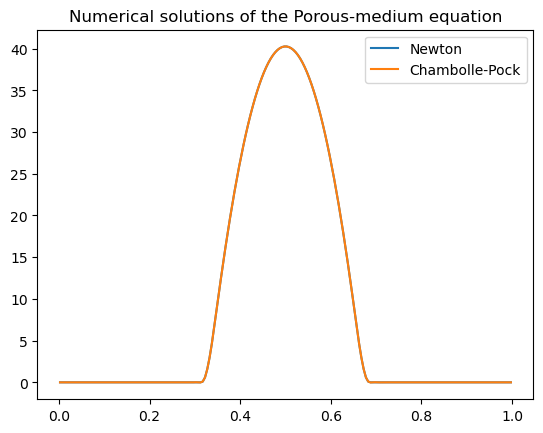

In [35]:
iT = 0 # Choose from 0 (initial condition) to  nT-1 (final time)
plt.title("Numerical solutions of the Porous-medium equation")
plt.plot(aX,uN[iT],label="Newton")
plt.plot(aX,uCP[iT],label="Chambolle-Pock")
plt.legend();

### 3.4 Two dimensions

In [36]:
nX = 35; nT = 6
#nX = 50; nT = 10 # bit longish
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT
Δϕpos = 0.5

In [37]:
%%time
# Solve the optimization problem in ϕ
ϕ0 = np.zeros((nT,*u0.shape))
ϕN = ad.Optimization.newton_minimize(Energy_ϕ,ϕ0.reshape(-1),(u0,dx,dt,Δϕpos),step_min=1e-8)
ϕN = ϕN.reshape(ϕ0.shape)
ρN,mN = ρm_from_ϕ(ϕN,dx,dt)

Initialization, objective 0.0
Iteration 1, Newton step 0.25, objective -375.00252143382437.


Iteration 2, Newton step 0.015625, objective -390.29833868581727.


Iteration 3, Newton step 0.03125, objective -411.08550984013954.


Iteration 4, Newton step 0.0625, objective -445.2442065697418.


Iteration 5, Newton step 0.125, objective -501.35118125756804.


Iteration 6, Newton step 0.125, objective -545.710499092698.


Iteration 8, Newton step 0.25, objective -639.5673191194612.


Iteration 10, Newton step 0.25, objective -732.8048550574883.


Iteration 12, Newton step 1.0, objective -781.871964813331.


Iteration 14, Newton step 1.0, objective -788.6039250223354.


Iteration 16, Newton step 1.0, objective -788.6379423429379.


Convergence criterion satisfied, terminating.
Iteration 20, Newton step 1.0, objective -788.6380038064068.
CPU times: user 15.5 s, sys: 19.2 s, total: 34.7 s
Wall time: 21.3 s


In [38]:
%%time
ρCP,mCP = run_CP(u0,dx,dt,nT,τ_f=1,maxiter=1000)
print("ρ relative error",norminf(ρCP-ρN)/norminf(ρN))
print("m relative error",norminf(mCP-mN)/norminf(mN))

ρ relative error 0.11072803949360746
m relative error 0.003971979741385771
CPU times: user 3.4 s, sys: 443 ms, total: 3.84 s
Wall time: 3.87 s


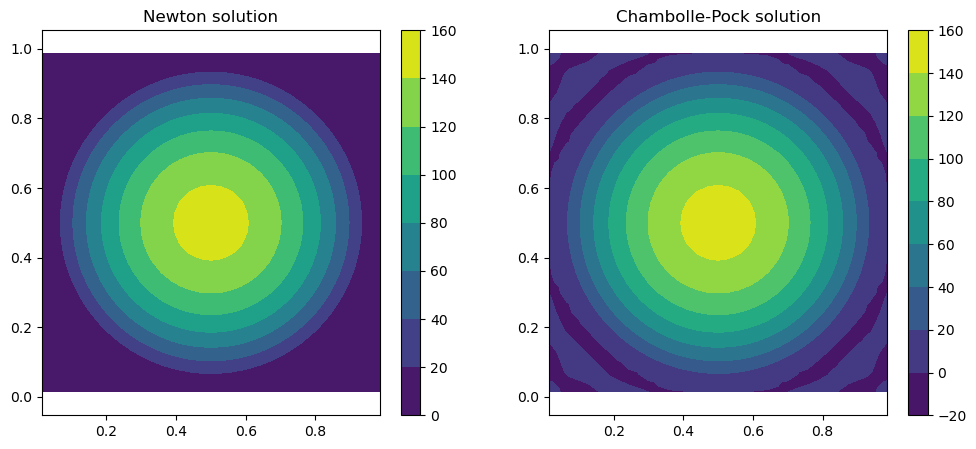

In [39]:
uN = u_from_ρm(ρN,mN); uCP = u_from_ρm(ρCP,mCP)

iT=nT-1 # Choose from 0 (initial) to nT-1 (final)
plt.figure(figsize=[12,5])
plt.subplot(1,2,1); plt.title("Newton solution")
plt.contourf(*X,uN[iT])
plt.axis('equal'); plt.colorbar();
plt.subplot(1,2,2); plt.title("Chambolle-Pock solution")
plt.contourf(*X,uCP[iT])
plt.axis('equal'); plt.colorbar();

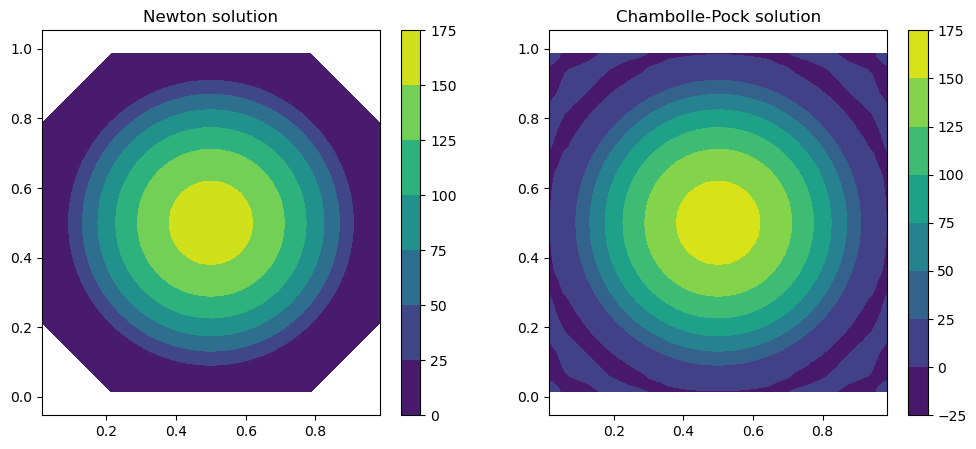

In [40]:
iT=4
plt.figure(figsize=[12,5])
plt.subplot(1,2,1); plt.title("Newton solution")
plt.contourf(*X,uN[iT])
plt.axis('equal'); plt.colorbar();
plt.subplot(1,2,2); plt.title("Chambolle-Pock solution")
plt.contourf(*X,uCP[iT])
plt.axis('equal'); plt.colorbar();

The Chambolle-Pock solution is rather close to the Newton solution, but it does have some negative values.

In [41]:
np.min(uN),np.min(uCP)

(-1.175494350818561e-38, -0.3992967467353444)

The Chambolle-Pock solution is closer to Newton than to the exact solution, because they solve the same discretized problem, and even though the primal-dual method was early stopped.

In [42]:
iT=nT-1 # Choose from 0 (initial) to nT-1 (final)

t = Ti+(iT+0.5)*dt
uExact = Barenblatt(t,X-0.5)
norminf(uN[iT]-uExact),norminf(uCP[iT]-uExact),norminf(uN-uCP)

(2.851154688066989, 3.2066905137182222, 0.4463030142136035)

## 4. Running on the GPU

We use the cupy, which allows to numpy code to the GPU, and to define custom kernels when needed.

In [43]:
if cp is None: raise ad.DeliberateNotebookError("Cupy needed for this notebook")

DeliberateNotebookError: Cupy needed for this notebook

The two main ingredients of the primal dual method are the (i) projection onto the constraint, and (ii) the proximal operator of the perspective function. Step (i) relies mainly on the fast fourier transform, for which optimized cuda routines are available, which are automatically called.

In [44]:
ρ_gpu,m_gpu = Fourier_proj_ρm(cp.array(ρ_rnd,dtype=np.float32),cp.array(m_rnd,dtype=np.float32),dx,dt,verb=0)
ρ_cpu,m_cpu = Fourier_proj_ρm(ρ_rnd,m_rnd,dx,dt,verb=0)
assert np.allclose(ρ_cpu,ρ_gpu,atol=1e-6)
assert np.allclose(m_cpu,m_gpu,atol=1e-6)

### 4.1 Kernel for the perspective function

Memory transfers usually bottleneck (insufficiently optimized) GPU code. 
For best efficiency, a custom gpu kernel should be done a lot of operations are done componentwise.
In the best of worlds, the `@cp.fuse` tag would be enough to create the kernel, but in practice a short C reimplementation is usually needed.
Some further profiling and kernel fusing of the routines would be needed in a serious implementation.

In [14]:
prox_perspective_kernel = cp.RawKernel(r'''
extern "C" __global__
void kernel(float tau, const float * eta_in, float * y_in, 
float * eta_out, float * y_out, unsigned int size, unsigned int niter){
const unsigned int tid = blockDim.x * blockIdx.x + threadIdx.x;
if(tid>=size){return;}
const float eta = eta_in[tid], y = y_in[tid];
if(tau*eta+y*y/2<=0){eta_out[tid]=0; y_out[tid]=0; return;} // to_origin
const float et2 = 2*(eta+tau), Ny = abs(y);
float s = max( pow(2*Ny/tau,float(1./3)), sqrt(max(float(0),-et2/tau)) ); 
for(int i=0; i<niter; ++i){ // Using a fixed number of iterations
    const float s2=s*s, s3=s*s2;
    s -= (tau*s3 + et2*s - 2*Ny) / (3*tau*s2+et2);
}
eta_out[tid] = eta+tau*s*s/2;
y_out[tid] = y==0 ? 0 : (1-tau*s/Ny)*y;
}''',"kernel")

def prox_perspective_cupy(τ,x_in,niter=12):
    assert x_in.flags['C_CONTIGUOUS'] # Never forget these two lines ! Will save hours of debugging.
    assert x_in.dtype==np.float32 
    
    x_out = np.empty_like(x_in)
    size = x_in[0].size
    blocksize = 1024
    gridsize = np.ceil(size/blocksize).astype(int)
    prox_perspective_kernel((gridsize,),(blocksize,),(np.float32(τ),x_in[0],x_in[1],x_out[0],x_out[1],size,niter))
    return x_out

Let us check that the cupy kernel agrees with the original implementation.

In [46]:
np.random.seed(42)
x0 = np.random.rand(2,1000)-0.5
x0 = cp.array(x0,dtype=np.float32)
τ = 0.5
assert np.allclose(prox_perspective_cupy(τ,x0), prox_perspective(τ,x0.get()),atol=1e-6)

In [47]:
np.random.seed(42)
x0 = np.random.rand(2,10**7)-0.5
x0 = cp.array(x0,dtype=np.float32)

And that a substantial speedup is achieved.

In [48]:
%%time
prox_perspective_cupy(τ,x0)

CPU times: total: 0 ns
Wall time: 0 ns


array([[ 0.03402805,  0.45450523,  0.2876059 , ...,  0.48728737,  0.        ,  0.        ],
       [ 0.02717886, -0.05596824,  0.13564752, ..., -0.22645545,  0.        ,  0.        ]], dtype=float32)

In [49]:
%%time
prox_perspective(τ,x0,cupy_kernel=False)

CPU times: total: 78.1 ms
Wall time: 101 ms


array([[ 0.03402805,  0.45450523,  0.2876059 , ...,  0.48728737,  0.        ,  0.        ],
       [ 0.02717886, -0.05596824,  0.13564752, ..., -0.22645545,  0.        ,  0.        ]], dtype=float32)

### 4.2 Reproducibility

In [61]:
nX = 5; nT = 3
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX+=dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))
#X=aX[None]

Ti = 2e-5
u0 = Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT

In [62]:
ρ_gpu,m_gpu = run_CP(cp.asarray(u0,dtype=np.float32),dx,dt,nT,τ_f=1.,maxiter=2)
ρ_cpu,m_cpu = run_CP(u0,dx,dt,nT,τ_f=1.,maxiter=2)
assert np.allclose(ρ_cpu,ρ_gpu,atol=1e-5)
assert np.allclose(m_cpu,m_gpu,atol=1e-4)

### 4.3 Larger test case

In [15]:
nX = 512; nT = 8 
aX,dx = np.linspace(0,1,nX,retstep=True,endpoint=False)
aX += dx/2
X = np.array(np.meshgrid(aX,aX,indexing='ij'))

Ti = 2e-5
u0 = Barenblatt(Ti,X-0.5)
Tf = 2e-4; T = Tf-Ti
dt = T/nT

In [18]:
%%time
ρ,m = run_CP(cp.asarray(u0,dtype=np.float32),dx,dt,nT,τ_f=1.,maxiter=500)

CPU times: total: 15.6 ms
Wall time: 14.8 s


In [19]:
u = u_from_ρm(ρ,m)
iT = nT-1
plt.contourf(*X,u[iT].get())
plt.axis('equal');